In [1]:
import sys

if str(type(sys.stdout)) == "<class 'ipykernel.iostream.OutStream'>":
    saved_std = sys.stdout
else:
    sys.stdout = saved_std

sys.stdout

In [2]:
#models:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier


#Preprocessing:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


#Other:
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('Data/modifiedData.csv', index_col='PassengerId')
test = pd.read_csv('Data/modifiedTest.csv', index_col='PassengerId')
y = df['Survived']
df.drop('Survived',axis=1,inplace=True)
display(df)
display(test)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Deck,hasNChildren,hasCabin,has1or2sib,has3PSib
PassengerId,,,,,,,,,,,,,
1,3,male,22.0,1,0,7.2500,S,Mr.,U,0,0,1,0
2,1,female,38.0,1,0,71.2833,C,Mrs.,C,0,1,1,0
3,3,female,26.0,0,0,7.9250,S,Miss.,U,0,0,0,0
4,1,female,35.0,1,0,53.1000,S,Mrs.,C,0,1,1,0
5,3,male,35.0,0,0,8.0500,S,Mr.,U,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,2,male,27.0,0,0,13.0000,S,Mr.,U,0,0,0,0
888,1,female,19.0,0,0,30.0000,S,Miss.,B,0,1,0,0
889,3,female,15.0,1,2,23.4500,S,Miss.,U,0,0,1,0


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Deck,hasNChildren,hasCabin,has1or2sib,has3PSib
PassengerId,,,,,,,,,,,,,
892,3,male,34.5,0,0,7.8292,Q,Mr.,U,0,0,0,0
893,3,female,47.0,1,0,7.0000,S,Mrs.,U,0,0,1,0
894,2,male,62.0,0,0,9.6875,Q,Mr.,U,0,0,0,0
895,3,male,27.0,0,0,8.6625,S,Mr.,U,0,0,0,0
896,3,female,22.0,1,1,12.2875,S,Mrs.,U,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,3,male,37.0,0,0,8.0500,S,Mr.,U,0,0,0,0
1306,1,female,39.0,0,0,108.9000,C,Mr.,C,0,1,0,0
1307,3,male,38.5,0,0,7.2500,S,Mr.,U,0,0,0,0


In [30]:
# Age & Fare were filled in using the appropriate distributions.
# SibSp & Parch will be filled in as 0
# Pclass & Embarked will be filled in with modal class (3rd and S, respectively) 

In [4]:
preSib = Pipeline(
    [('Sib_NA', SimpleImputer(strategy='constant', fill_value=0)), ('Scaler', StandardScaler())])

preSibNoScale = Pipeline(
    [('Sib_NA', SimpleImputer(strategy='constant', fill_value=0))])

preClass = Pipeline([('Class_NA', SimpleImputer(
    strategy='most_frequent')), ("OHE", OneHotEncoder(handle_unknown='ignore'))])

# handle_unknown='ignore' means that if the OHE encounters a class it doesn't recognize when transforming,
# it'll continue instead of throwing an error.

scaledFeat = ['Age', 'Fare', 'hasNChildren', 'hasCabin', 'has1or2sib', 'has3PSib']
filledFeat = ['SibSp', 'Parch']
catFeat = ['Sex', 'Deck', 'Title', 'Embarked', 'Pclass']

Preprocess = ColumnTransformer([('Scaler', StandardScaler(), scaledFeat),
                                ('FillNA', preSib, filledFeat),
                                ('OHE', preClass, catFeat)])

PreprocessNoScale = ColumnTransformer([('Identitey', FunctionTransformer(), scaledFeat),
                                       ('FillNA', preSib, filledFeat),
                                       ('OHE', preClass, catFeat)])

The models I'm using are those suggested [here](https://www.kaggle.com/kenjee/titanic-project-example)

In [32]:
gnb_pipe = Pipeline([('Preprocess',Preprocess),('GNB',GaussianNB())])
cv = cross_val_score(gnb_pipe,df,y,cv=5)
print(cv.mean())

0.7677170296905406


In [33]:
tree_pipe = Pipeline([('Preprocess',Preprocess),('Tree',tree.DecisionTreeClassifier(random_state=7))])
cv = cross_val_score(tree_pipe,df,y,cv=5)
print(cv.mean())

0.7620802209528592


In [34]:
SVC_pipe = Pipeline([('Preprocess',Preprocess),('SVC',SVC(probability = True))])
cv = cross_val_score(SVC_pipe,df,y,cv=5)
print(cv.mean()) # Maybe try one with less overlapping features.

0.827154604230745


In [35]:
xgb_pipe = Pipeline([('Preprocess',Preprocess),
                     ('xgb',XGBClassifier(random_state=7,use_label_encoder=False,eval_metric='logloss'))])
cv = cross_val_score(xgb_pipe,df,y,cv=5)
print(cv.mean()) # Maybe try one with less overlapping features.

0.8114744837110036


In [36]:
RF_pipe = Pipeline([('Preprocess',Preprocess),('RF',RandomForestClassifier(random_state=7))])
cv = cross_val_score(RF_pipe,df,y,cv=5)
print(cv.mean())

0.8024731655263324


In [37]:
KNN_pipe = Pipeline([('Preprocess',Preprocess),('KNN',KNeighborsClassifier())])
cv = cross_val_score(KNN_pipe,df,y,cv=5)
print(cv.mean())

0.7957504237022157


In [38]:
logreg_pipe = Pipeline([('Preprocess',Preprocess),('Logreg',LogisticRegression())])
cv = cross_val_score(logreg_pipe,df,y,cv=5)
print(cv.mean())

0.8249325214989642


In [39]:
voting_clf = VotingClassifier(estimators = [('lr',logreg_pipe),('knn',KNN_pipe),('rf',RF_pipe),
                                            ('svc',SVC_pipe),('xgb',xgb_pipe)], voting = 'soft')
cv = cross_val_score(voting_clf,df,y,cv=5)
print(cv.mean())

0.8350260498399347


In [40]:
voting_clf.fit(df,y)
data = np.array([test.index, voting_clf.predict(test)]).T
noTunePred = pd.DataFrame(data = data, columns = ['PassengerId','Survived'])
noTunePred.to_csv('Predictions/basePrediction.csv', index=False)

In [5]:
#simple performance reporting function
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

### TO DO (bare minimum):
1. ~~Make better grid for logreg~~
1. ~~Same for KNN~~
1. ~~And RandomForest~~
1. ~~Combine all models to voting model.~~

### IN THE FUTURE:
1. Change classifier scoring method to better reflect dataset.
1. Play with weights in voting model
1. Try to lessen the over-fitting

In [31]:
# logreg_pipe = Pipeline([('Preprocess',Preprocess),('Logreg',LogisticRegression())])

# param_grid = {'Logreg__max_iter' : [2000],
#               'Logreg__penalty' : ['l2'],
#               'Logreg__C' :  np.logspace(-4, 4, 17),
#               'Logreg__solver' : ['newton-cg', 'lbfgs', 'liblinear']}

# lr_grid = GridSearchCV(logreg_pipe, param_grid=param_grid, verbose = 1, n_jobs = -1)
# best_lr = lr_grid.fit(df,y)
# print('Done with grid :)\n')

# clf_performance(best_lr,'Logistic Regression')

best_lr = Pipeline([('Preprocess',Preprocess),('Logreg',LogisticRegression(n_jobs=-1, penalty='l2', C=31.62277, solver='newton-cg'))])
best_lr.fit(df,y)
print('Done :)')

Done :)


In [30]:
# knn_pipe = Pipeline([('Preprocess',Preprocess),('KNN',KNeighborsClassifier())])

# param_grid = {'KNN__n_neighbors' : range(1,12,2),
#               'KNN__weights' : ['uniform', 'distance'],
#               'KNN__p' : [1,2]}
# n_neighbors=7, p=1, weights='uniform'

# param_grid = {'KNN__n_neighbors' : range(6,9,1),
#               'KNN__weights' : ['uniform'],
#               'KNN__p' : [1]}
# Same result.

# param_grid = {'KNN__n_neighbors' : [7],
#               'KNN__weights' : ['uniform'],
#               'KNN__p' : [1]}

# knn_grid = GridSearchCV(knn_pipe, param_grid=param_grid, verbose = 1, n_jobs = -1, cv=5)
# best_knn = knn_grid.fit(df,y)
# print('Done with grid :)\n')

# clf_performance(best_knn,'KNN')

best_knn = Pipeline([('Preprocess',Preprocess),('KNN',KNeighborsClassifier(n_neighbors=7, n_jobs=-1, p=1))])
best_knn.fit(df,y)
print('Done :)')

Done :)


In [24]:
# SVC_pipe = Pipeline([('Preprocess', Preprocess),
#                     ('SVC', SVC(probability=True))])

# param_grid = tuned_parameters = [{'SVC__kernel': ['linear'], 'SVC__C': [10**i for i in range(-1,2)]},
#                                  {'SVC__kernel': ['rbf'], 'SVC__gamma': [.1, 1, 10, 'auto'],
#                                   'SVC__C': [10**i for i in range(-1,2)]},
#                                  {'SVC__kernel': ['poly'], 'SVC__degree': range(2,7,2),
#                                   'SVC__C': [10**i for i in range(-1,2)]}]
# final score: 0.829
# kernel = 'poly', degree = 2, C = 1

# param_grid = tuned_parameters = [{'SVC__kernel': ['poly'], 'SVC__degree': [2,3],
#                                   'SVC__C': [i/10 for i in range (9,12,1)]}]
# Same result.

# SVC_grid = GridSearchCV(SVC_pipe, param_grid=param_grid, verbose=1)
# best_SVC = SVC_grid.fit(df, y)
# print('Done with grid :)\n')

# clf_performance(best_SVC, 'SVC')

best_SVC = Pipeline([('Preprocess', Preprocess),
                    ('SVC', SVC(probability=True, kernel='poly', C=1, degree=2))])
best_SVC.fit(df,y)
print('Done :)')

Done :)


In [23]:
# RF_pipe = Pipeline([('Preprocess', Preprocess),
#                    ('RF', RandomForestClassifier(random_state=7))])


# param_grid = {'RF__n_estimators': [400, 450, 500, 550, 700, 900],
#               'RF__max_features': ['auto', 'sqrt', 0.2],
#               'RF__min_samples_leaf': [2,5,10]}
# final score (auc): 0.87
# 'auto', 5, 900

# param_grid = {'RF__n_estimators': range(800, 1001, 50),
#               'RF__max_features': ['auto'],
#               'RF__min_samples_leaf': range(3,7)}
# final score (auc): 0.87, tiny bit better.
# 5, 850


# RF_grid = GridSearchCV(
#     RF_pipe, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1, scoring='roc_auc')
# best_RF = RF_grid.fit(df, y)
# print('Done with grid :)\n')

# clf_performance(best_RF, 'Random Forest')

best_RF = Pipeline([('Preprocess', Preprocess),
                   ('RF', RandomForestClassifier(random_state=7, min_samples_leaf= 5, n_estimators=850, n_jobs=-1))])

best_RF.fit(df,y)
print('Done :)')

Done :)


In [26]:
# xgb_pipe = Pipeline([('Preprocess', Preprocess),
#                      ('xgb', XGBClassifier(random_state=7, use_label_encoder=False, eval_metric='logloss'))])

# Needs a bit of sorting.
# param_grid = {
#     'xgb__n_estimators':range(100,220,10),
#     'xgb__min_child_weight': [1],
#     'xgb__max_depth':[5],
#     'xgb__learning_rate':[0.05],
#     'xgb__subsample':[0.8],
#     'xgb__colsample_bytree':[0.8],
#     'xgb__gamma':[0],
#     'xgb__scale_pos_weight':[1],
#     'xgb__objective':['binary:logistic']
# }
# final score: 0.837
# from this we get that n_estimators = 160 is the best for learning rate of 0.05

# param_grid = {
#     'xgb__n_estimators':[160],
#     'xgb__min_child_weight': range(1,6,2),
#     'xgb__max_depth': range(3,10,2),
#     'xgb__learning_rate':[0.05],
#     'xgb__subsample':[0.8],
#     'xgb__colsample_bytree':[0.8],
#     'xgb__gamma':[0],
#     'xgb__scale_pos_weight':[1],
#     'xgb__objective':['binary:logistic']
# }
# final score: 0.8395
# max_depth = 5, min_child_weight = 3

# param_grid = {
#     'xgb__n_estimators':[160],
#     'xgb__min_child_weight': [2,3,4],
#     'xgb__max_depth': [4,5,6],
#     'xgb__learning_rate':[0.05],
#     'xgb__subsample':[0.8],
#     'xgb__colsample_bytree':[0.8],
#     'xgb__gamma':[0],
#     'xgb__scale_pos_weight':[1],
#     'xgb__objective':['binary:logistic']
# }
# final score: 0.842
# max_depth = 6, min_child_weight = 3

# param_grid = {
#     'xgb__n_estimators':[160],
#     'xgb__min_child_weight': [3],
#     'xgb__max_depth': [6],
#     'xgb__learning_rate':[0.05],
#     'xgb__subsample':[0.8],
#     'xgb__colsample_bytree':[0.8],
#     'xgb__gamma':[i/10.0 for i in range(0,5)],
#     'xgb__scale_pos_weight':[1],
#     'xgb__objective':['binary:logistic']
# }
# gamma is best left untouched

# param_grid = {
#     'xgb__n_estimators':range(150,210,5),
#     'xgb__min_child_weight': [3],
#     'xgb__max_depth': [6],
#     'xgb__learning_rate':[0.05],
#     'xgb__subsample':[0.8],
#     'xgb__colsample_bytree':[0.8],
#     'xgb__gamma':[0],
#     'xgb__scale_pos_weight':[1],
#     'xgb__objective':['binary:logistic']
# }
# just checking if it's still the best number of n_estimators.
# final score: 0.843
# n_estimators = 155

# param_grid = {
#     'xgb__n_estimators':[155],
#     'xgb__min_child_weight': [3],
#     'xgb__max_depth': [6],
#     'xgb__learning_rate':[0.05],
#     'xgb__subsample':[i/10.0 for i in range(6,10)],
#     'xgb__colsample_bytree':[i/10.0 for i in range(6,10)],
#     'xgb__gamma':[0],
#     'xgb__scale_pos_weight':[1],
#     'xgb__objective':['binary:logistic']
# }
# final score: 0.843
# subsample, colsample = 0.8

# param_grid = {
#     'xgb__n_estimators':[155],
#     'xgb__min_child_weight': [3],
#     'xgb__max_depth': [6],
#     'xgb__learning_rate':[0.05],
#     'xgb__subsample':[i/100.0 for i in range(75,90,5)],
#     'xgb__colsample_bytree':[i/100.0 for i in range(75,90,5)],
#     'xgb__gamma':[0],
#     'xgb__scale_pos_weight':[1],
#     'xgb__objective':['binary:logistic']
# }
# still the same.

# param_grid = {
#     'xgb__n_estimators':[155],
#     'xgb__min_child_weight': [3],
#     'xgb__max_depth': [6],
#     'xgb__learning_rate':[0.05],
#     'xgb__subsample':[0.8],
#     'xgb__colsample_bytree':[0.8],
#     'xgb__gamma':[0],
#     'xgb__scale_pos_weight':[1],
#     'xgb__objective':['binary:logistic'],
#     'xgb__reg_alpha':[0, 1e-5, 1e-4, 1e-3],
#     'xgb__reg_lambda':[0.05,0.1,0.15]
# }
# final score: 0.843
# alpha: 0, lambda: 0.1

# param_grid = {
#     'xgb__n_estimators':range(140,250,10),
#     'xgb__min_child_weight': [3],
#     'xgb__max_depth': [6],
#     'xgb__learning_rate': [i/1000 for i in range(30,100,5)],
#     'xgb__subsample':[0.8],
#     'xgb__colsample_bytree':[0.8],
#     'xgb__gamma':[0],
#     'xgb__scale_pos_weight':[1],
#     'xgb__objective':['binary:logistic'],
#     'xgb__reg_alpha':[0],
#     'xgb__reg_lambda':[0.1]
# }
# final score: 0.845
# n_extimators = 190, learning_rate = 0.065

# param_grid = {
#     'xgb__n_estimators': [190],
#     'xgb__min_child_weight': [3],
#     'xgb__max_depth': [6],
#     'xgb__learning_rate': [0.065],
#     'xgb__subsample': [0.8],
#     'xgb__colsample_bytree': [0.8],
#     'xgb__gamma': [0],
#     'xgb__scale_pos_weight': [1],
#     'xgb__objective': ['binary:logistic'],
#     'xgb__reg_alpha': [0],
#     'xgb__reg_lambda': [0.1]
# }

# xgb_grid = GridSearchCV(
#     xgb_pipe, param_grid=param_grid, cv=5, verbose=1)
# best_xgb = xgb_grid.fit(df, y)
# print('Done with grid :)\n')
# clf_performance(best_xgb, 'XGBoost')

processedDF = Preprocess.fit_transform(df)
best_xgb = XGBClassifier(random_state=7, use_label_encoder=False, eval_metric='logloss',
                         n_estimators=190, min_child_weight=3, max_depth=6, learning_rate=0.065,
                         subsample=0.8, colsample_bytree=0.8, gamma=0, scale_pos_weight=1,
                         objective='binary:logistic', reg_alpha=0, reg_lambda=0.1)

best_xgb.fit(processedDF, y)
print('Done :)')

Done :)


In [76]:
transTest = Preprocess.transform(test)
data = np.array([test.index, best_xgb.predict(transTest)]).T
tunedXGB = pd.DataFrame(data = data, columns = ['PassengerId','Survived'])
tunedXGB.to_csv('Predictions/tunedXGBPrediction.csv', index=False) # Seems over-fitted. got 76.7%

Feature importance:

First, I'll have to get the feature names:

Text(0.5, 0, 'Xgboost Feature Importance')

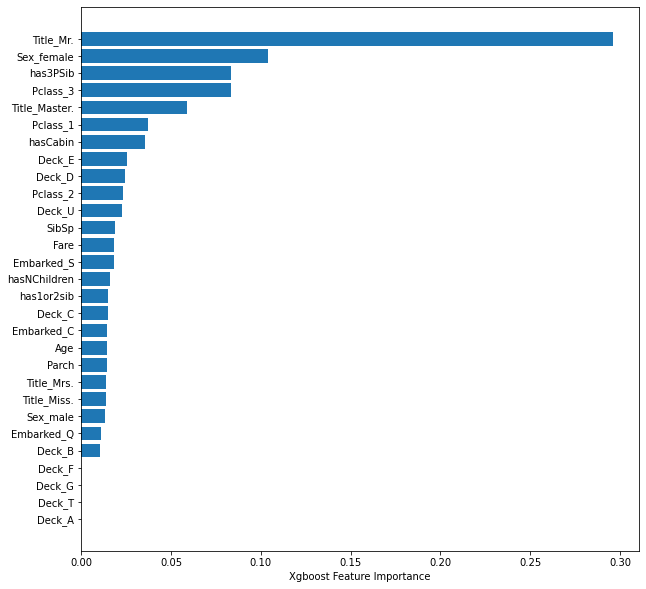

In [86]:
oheFeat = Preprocess.transformers_[2][1]['OHE'].get_feature_names(catFeat)
# Preprocess.transformers_ is a list: [('Name', Transformer, Columns)] and so, 
# Preprocess.transformers_[2] is the 3rd transformer's truple (OHE Pipeline).
# We then pick the transformer itself in the truple: Preprocess.transformers_[2][1].
# This is a pipeline, so we specify which transformer we want from it: Preprocess.transformers_[2][1]['OHE'].
# We then get the feature names using OHE's attribute.
featNames = np.concatenate([scaledFeat,filledFeat,oheFeat])

sorted_idx = best_xgb.feature_importances_.argsort()
plt.rcParams['figure.figsize'] = [10, 10]
plt.barh(featNames[sorted_idx], best_xgb.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

from this it seems that we could try to only include "hasCabin" and get rid of the "Deck".  
I'd also like to get rid of 'has1or2sib'.  
'hasNChildren' is a success, as it's better at predicting than 'parch'. however, that may be because it includes title info.

In [115]:
modScaledFeat = ['Age', 'Fare', 'hasCabin', 'hasNChildren']
modFilledFeat = ['SibSp', 'Parch']
modCatFeat = ['Sex', 'Title', 'Embarked', 'Pclass']

modPreprocess = ColumnTransformer([('Scaler', StandardScaler(), modScaledFeat),
                                   ('FillNA', preSib, modFilledFeat),
                                   ('OHE', preClass, modCatFeat)])

In [119]:
best_xgb_pipe = Pipeline([('modPre', modPreprocess),
                          ('best_xgb', XGBClassifier(random_state=7, use_label_encoder=False, eval_metric='logloss',
                                                     n_estimators=190, min_child_weight=3, max_depth=6, learning_rate=0.065,
                                                     subsample=0.8, colsample_bytree=0.8, gamma=0, scale_pos_weight=1,
                                                     objective='binary:logistic', reg_alpha=0, reg_lambda=0.1))])

cv = cross_val_score(best_xgb_pipe, df, y, cv=5)
print(cv)

best_xgb_pipe.fit(df,y)
data = np.array([test.index, best_xgb_pipe.predict(test)]).T
modXGB = pd.DataFrame(data = data, columns = ['PassengerId','Survived'])
modXGB.to_csv('Predictions/modXGBPrediction.csv', index=False) # Even worse, was worth a try :)

[0.83240223 0.80337079 0.86516854 0.83707865 0.85955056]


In [37]:
best_xgb_pipe = Pipeline([('Preprocess', Preprocess),
                          ('best_xgb', XGBClassifier(random_state=7, use_label_encoder=False, eval_metric='logloss',
                                                     n_estimators=190, min_child_weight=3, max_depth=6, learning_rate=0.065,
                                                     subsample=0.8, colsample_bytree=0.8, gamma=0, scale_pos_weight=1,
                                                     objective='binary:logistic', reg_alpha=0, reg_lambda=0.1))])

best_voting_clf = VotingClassifier(estimators = [('lr', best_lr),('knn', best_knn),('rf', best_RF),
                                            ('svc', best_SVC),('xgb', best_xgb_pipe)], voting = 'soft')
cv = cross_val_score(best_voting_clf,df,y,cv=5, scoring='roc_auc')
print(cv.mean())

0.8316427091833531


In [38]:
best_voting_clf.fit(df,y)
data = np.array([test.index, best_voting_clf.predict(test)]).T
tunePred = pd.DataFrame(data = data, columns = ['PassengerId','Survived'])
tunePred.to_csv('Predictions/tunedPrediction.csv', index=False)

This submission put me in the 2204th place, out of ~50K with a score of 78.468% which is an improvement! :)